In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the path to your dataset folder
dataset_path = '/content/drive/My Drive/Dataset'


# List files in the folder to confirm access
os.listdir(dataset_path)


['complaints_processed.csv']

In [ ]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
#importing necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import SMOTE
import joblib


In [ ]:
import pandas as pd

# Replace 'dataset.csv' with the name of your file
file_path = os.path.join(dataset_path, 'complaints_processed.csv')
df = pd.read_csv(file_path)

df.head(10)



,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
# dropping the unnecessary 'Unnamed: 0' column.
df = df.drop(columns=['Unnamed: 0'])
# dropping rows with missing values in the narrative column
df = df.dropna(subset=['narrative'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162411 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [ ]:
#checking for duplicate rows on 'product','narrative'
duplicates = df.duplicated(subset=['product','narrative']).sum()
duplicates

37735

In [ ]:
# checking the distribution of the 'product' categories
product_dist = df['product'].value_counts()
product_dist

,count
product,
credit_reporting,91172
debt_collection,23148
mortgages_and_loans,18990
credit_card,15566
retail_banking,13535


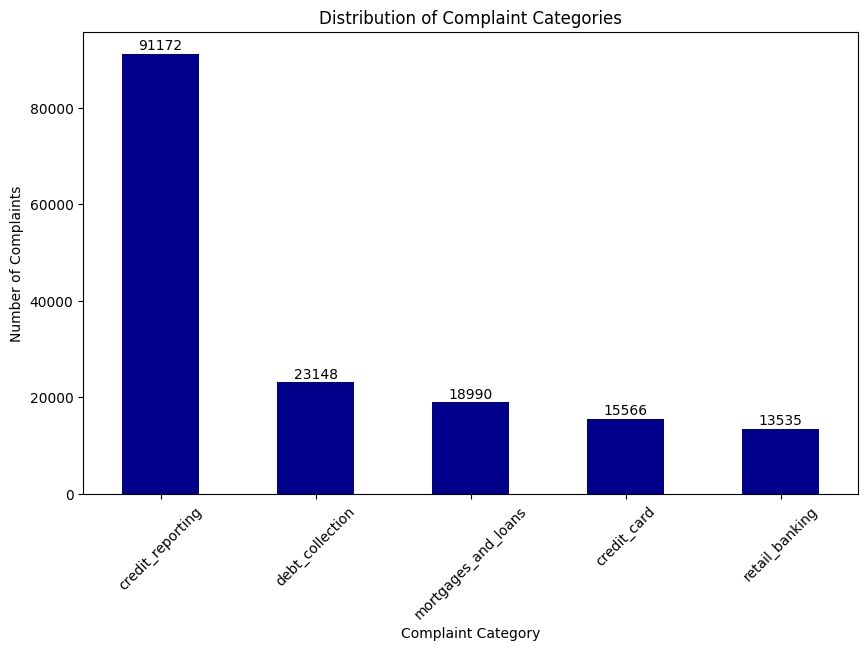

In [ ]:
# plotting the distribution of complaint categories.
plt.figure(figsize=(10,6))
ax = product_dist.plot(kind='bar',color='darkblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)

#adding count on top of each bar.
for i,count in enumerate(product_dist):
    ax.text(i,count + 200,str(count),ha='center',va='bottom')
plt.show()

The distribution shows a class imbalance,with credit_reporting category significantly more represented than others.
 I accounted for the imbalance through stratify parameter when separating the features and target to ensure that the class distribution in the training and testing sets matches that of the original dataset.

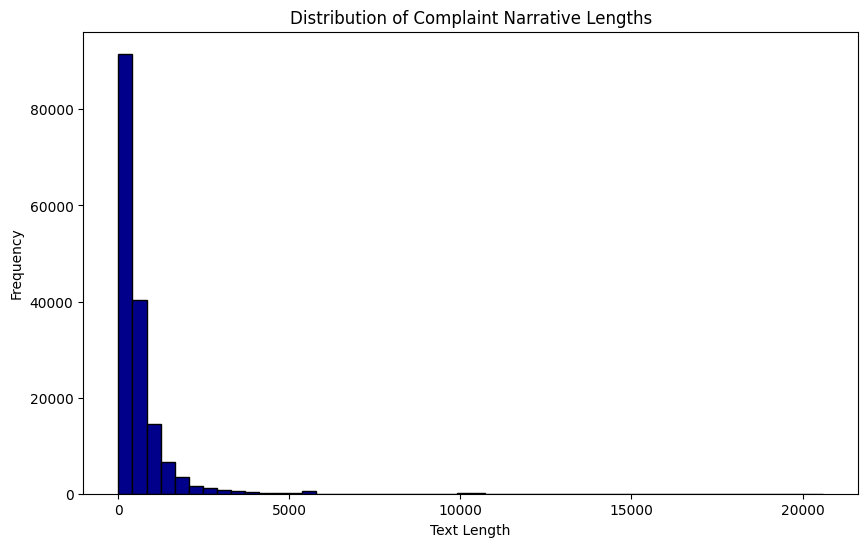

,text_length
count,162411.000000
mean,588.535838
std,830.977413
min,3.000000
25%,192.000000
50%,361.000000
75%,683.000000
max,20596.000000


In [ ]:
# Calculating the length of each complainy narrative
df['text_length'] = df['narrative'].apply(len)
text_length_summary = df['text_length'].describe()

#plotting the distribution of the text length.
plt.figure(figsize=(10,6))
plt.hist(df['text_length'],bins=50,color='darkblue',edgecolor='black')
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

text_length_summary

The histogram indicates a right-skewed distribution,with most narrative having fewer than 1000 characters .This information helps in choosing an appropriate text preprocessing approach and handling extremely short or long complaints if necessary.

In [ ]:
import nltk

try:
    wordnet_path = nltk.data.find("corpora/wordnet")
    print("WordNet is located at:", wordnet_path)
except LookupError:
    print("WordNet corpus not found.")

WordNet corpus not found.


In [ ]:
!pip install nltk


In [ ]:
import nltk
import os

# Specify a directory in Colab for NLTK data
nltk_data_dir = "/content/nltk_data"

# Create the directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

# Set the NLTK data path to point to this directory
nltk.data.path.append(nltk_data_dir)

# Download required resources to the specified directory
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)
nltk.download("omw-1.4", download_dir=nltk_data_dir)

# Verify that the NLTK data is accessible
print("NLTK data path:", nltk.data.path)



[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data] Downloading package omw-1.4 to /content/nltk_data...


NLTK data path: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data']


In [ ]:
wordnet_path = os.path.join(nltk_data_dir, "corpora", "wordnet")
stopwords_path = os.path.join(nltk_data_dir, "corpora", "stopwords")

print("WordNet directory exists:", os.path.exists(wordnet_path))
print("Stopwords directory exists:", os.path.exists(stopwords_path))

WordNet directory exists: False
Stopwords directory exists: True


In [ ]:
print("WordNet directory exists:", os.path.exists(wordnet_path))

WordNet directory exists: False


In [ ]:
import os

for root, dirs, files in os.walk(nltk_data_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)

Root: /content/nltk_data
Directories: ['tokenizers', 'corpora']
Files: []
----------------------------------------
Root: /content/nltk_data/tokenizers
Directories: ['punkt']
Files: ['punkt.zip']
----------------------------------------
Root: /content/nltk_data/tokenizers/punkt
Directories: ['PY3']
Files: ['estonian.pickle', 'german.pickle', 'greek.pickle', 'danish.pickle', 'spanish.pickle', 'portuguese.pickle', 'slovene.pickle', 'README', 'norwegian.pickle', '.DS_Store', 'polish.pickle', 'english.pickle', 'malayalam.pickle', 'finnish.pickle', 'dutch.pickle', 'italian.pickle', 'russian.pickle', 'french.pickle', 'turkish.pickle', 'swedish.pickle', 'czech.pickle']
----------------------------------------
Root: /content/nltk_data/tokenizers/punkt/PY3
Directories: []
Files: ['estonian.pickle', 'german.pickle', 'greek.pickle', 'danish.pickle', 'spanish.pickle', 'portuguese.pickle', 'slovene.pickle', 'README', 'norwegian.pickle', 'polish.pickle', 'english.pickle', 'malayalam.pickle', 'finnish

In [ ]:
import zipfile
import os

# Directory containing the zipped files
nltk_data_dir = "/content/nltk_data"

# Walk through the directories and extract all .zip files
for root, dirs, files in os.walk(nltk_data_dir):
    for file in files:
        if file.endswith('.zip'):
            file_path = os.path.join(root, file)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(root)  # Extract to the current directory
            print(f"Extracted: {file_path}")



Extracted: /content/nltk_data/tokenizers/punkt.zip
Extracted: /content/nltk_data/corpora/wordnet.zip
Extracted: /content/nltk_data/corpora/stopwords.zip
Extracted: /content/nltk_data/corpora/omw-1.4.zip


In [ ]:
for root, dirs, files in os.walk(nltk_data_dir):
    print("Root:", root)
    print("Directories:", dirs)
    print("Files:", files)
    print("-" * 40)


Root: /content/nltk_data
Directories: ['tokenizers', 'corpora']
Files: []
----------------------------------------
Root: /content/nltk_data/tokenizers
Directories: ['punkt']
Files: ['punkt.zip']
----------------------------------------
Root: /content/nltk_data/tokenizers/punkt
Directories: ['PY3']
Files: ['estonian.pickle', 'german.pickle', 'greek.pickle', 'danish.pickle', 'spanish.pickle', 'portuguese.pickle', 'slovene.pickle', 'README', 'norwegian.pickle', '.DS_Store', 'polish.pickle', 'english.pickle', 'malayalam.pickle', 'finnish.pickle', 'dutch.pickle', 'italian.pickle', 'russian.pickle', 'french.pickle', 'turkish.pickle', 'swedish.pickle', 'czech.pickle']
----------------------------------------
Root: /content/nltk_data/tokenizers/punkt/PY3
Directories: []
Files: ['estonian.pickle', 'german.pickle', 'greek.pickle', 'danish.pickle', 'spanish.pickle', 'portuguese.pickle', 'slovene.pickle', 'README', 'norwegian.pickle', 'polish.pickle', 'english.pickle', 'malayalam.pickle', 'finnish

In [ ]:
import nltk

try:
    wordnet_path = nltk.data.find("corpora/wordnet")
    print("WordNet is located at:", wordnet_path)
except LookupError:
    print("WordNet corpus not found.")

WordNet is located at: /content/nltk_data/corpora/wordnet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the nltk_data directory to Google Drive
!cp -r /content/nltk_data "/content/drive/My Drive/nltk_data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C


In [ ]:
nltk_data_dir = "/content/drive/My Drive/nltk_data"
nltk.data.path.append(nltk_data_dir)


In [ ]:
!pip install nltk

import nltk
import os

# Specify a directory in Colab for NLTK data
nltk_data_dir = "/content/nltk_data"

# Create the directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

# Set the NLTK data path to point to this directory
nltk.data.path.append(nltk_data_dir)

# Download required resources to the specified directory
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)
nltk.download("omw-1.4", download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir) # Download punkt_tab


# Verify that the NLTK data is accessible
print("NLTK data path:", nltk.data.path)

from google.colab import drive
drive.mount('/content/drive')

# Copy the nltk_data directory to Google Drive
!cp -r /content/nltk_data "/content/drive/My Drive/nltk_data"

nltk_data_dir = "/content/drive/My Drive/nltk_data"
nltk.data.path.append(nltk_data_dir)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string with whitespace handling
    cleaned_text = ' '.join(words).strip()  # Remove leading/trailing whitespace
    return ' '.join(cleaned_text.split())    # Replace multiple spaces with a single space

# Apply preprocessing to the 'narrative' column
df['cleaned_narrative'] = df['narrative'].apply(preprocess_text)
df[['narrative','cleaned_narrative']].head()

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /content/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK data path: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data', '/content/drive/My Drive/nltk_data', '/content/nltk_data']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,narrative,cleaned_narrative
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


Key steps included:
#### Lowercasing
Ensures uniformity.
#### Removing Special Characters and Numbers.
Cleans up non-essential elements.
#### Tokenization.
Splits text into words.
#### Stop Word Removal.
Filters out common but non-informative words.
#### Lemmatization.
Reduces words to their root forms.
#### Whitespace Handling.
Trims leading/trailing whitespace and replaces multiples spaces with a single space for consistency.

 The pipeline gives a well-processed cleaned_narrative column,ready for further transformation into numerical features using appropriate techniques.

In [ ]:
#counting words in each complaint
df['word_count'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))

#getting summary statistics for word counts
word_count_summary = df['word_count'].describe()
print('Word Count Summary:\n',word_count_summary)

Word Count Summary:
 count    162411.000000
mean         80.207935
std         108.821314
min           1.000000
25%          27.000000
50%          50.000000
75%          95.000000
max        2684.000000
Name: word_count, dtype: float64


The word count summary shows that the complaints vary widely in length,with an average of 80 words and a median of 50 words.The standard deviation of 108 suggests significant variability,and the range spans from 1 to 2,684 words,indicating some complaints are very brief while others are extremely detailed.This
distribution is right-skewed,with a small number of long complaints inflating the mean.While experimenting on preprocessing and modelling,I noted that filtering the words didn't further didn't improve the models so i kept them as they are

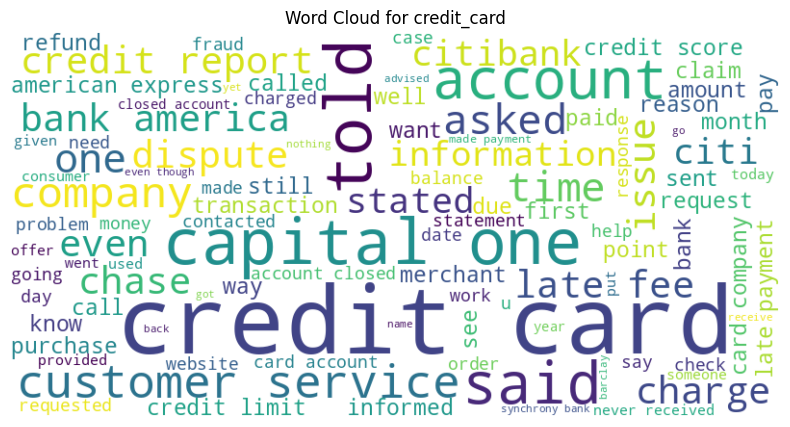

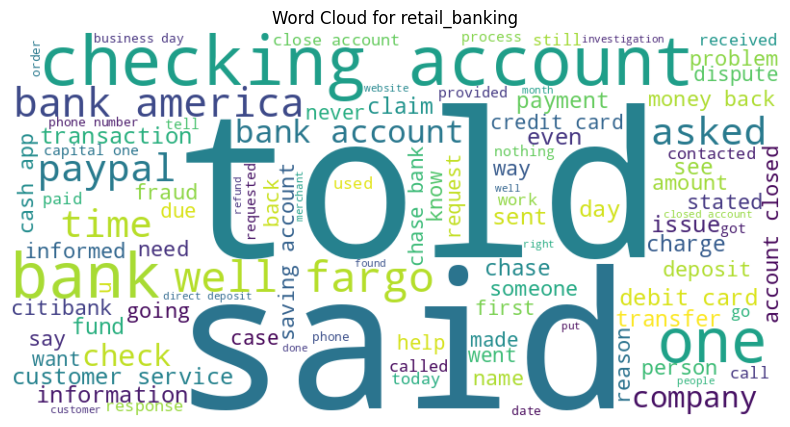

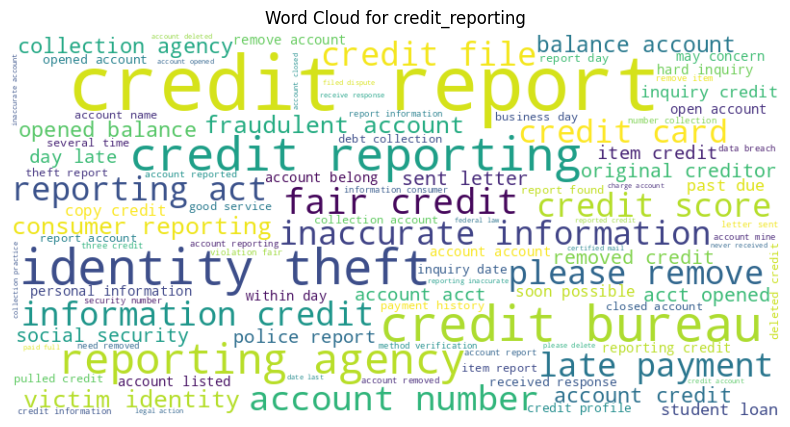

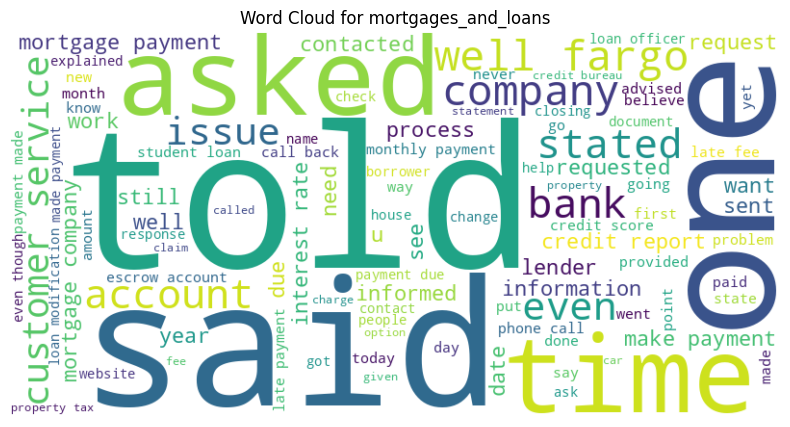

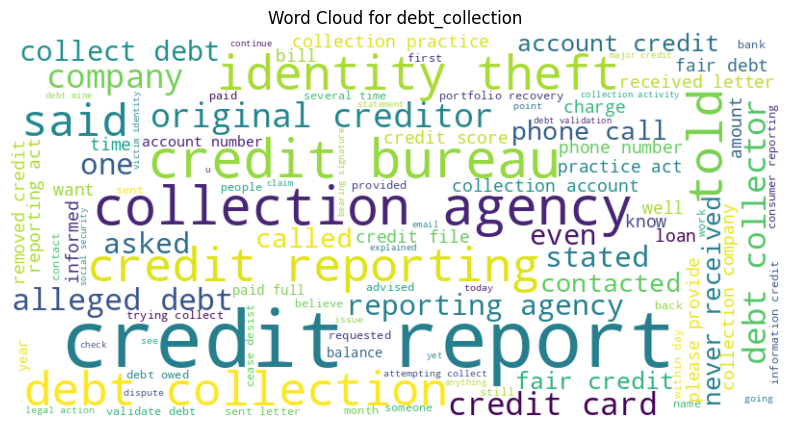

In [ ]:
#function to generate word cloud for each product label
def generate_word_cloud(data,product_label):
    text = ' '.join(data['cleaned_narrative'][data['product'] == product_label])
    wordcloud = WordCloud(width=800, height=400,background_color = 'white',max_words=100).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(f'Word Cloud for {product_label}')
    plt.axis('off')
    plt.show()

#getting unique product labels
product_labels = df['product'].unique()

#generating and displaying word cloud for each product
for label in product_labels:
    generate_word_cloud(df,label)

Word clouds for each product label:

1.**Credit Card**:Key terms include "credit card","charge","account","dispute", and "customer service","indicating frequent issues around charges,disputes and account management with credit card providers.

2.**Retail Banking**:Words like "checking","transaction","account","bank",'debit' appear prominently,suggesting common complaints related to checking accounts,bank transactions and debit cards.

3.**Credit Reporting**:Key words include 'credit report','bureau','identity theft' and 'inaccurate information','reflecting common issues with credit report accuracy,identity theft and dealing with credit bureaus.

4.**Mortgages and Loans**:Words like 'loan','mortgage','payment','account'and 'lender' dominate,pointing to frequent concerns with loan applications,mortgage payments,and interactions with lenders.

5.**Debt Collection**:Terms like 'debt','collection','credit report','creditor' and 'identity theft'are prevalent,indicating issues around debt collection practices,credit reporting and identity related problems

Each word cloud highlights some terms associated with common issues for each product.This shows that customer complaints are centered around distinct themes based on the product type.

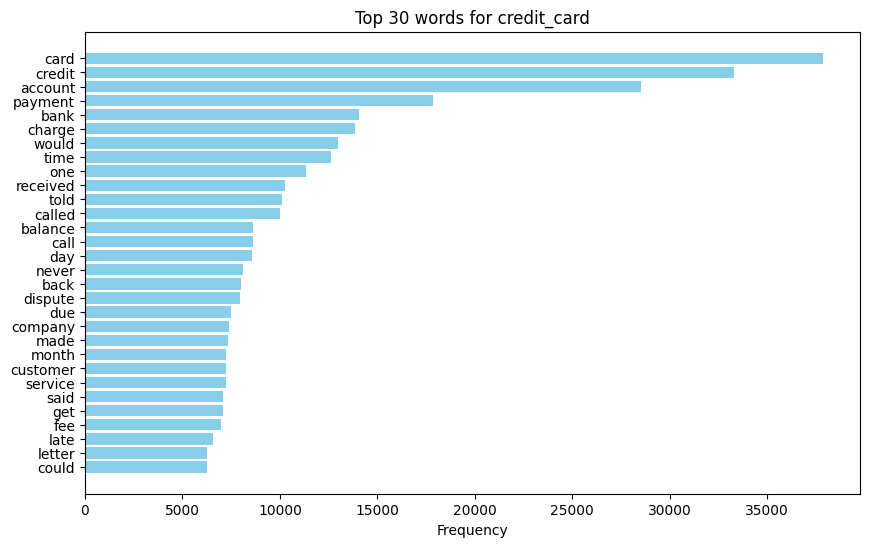

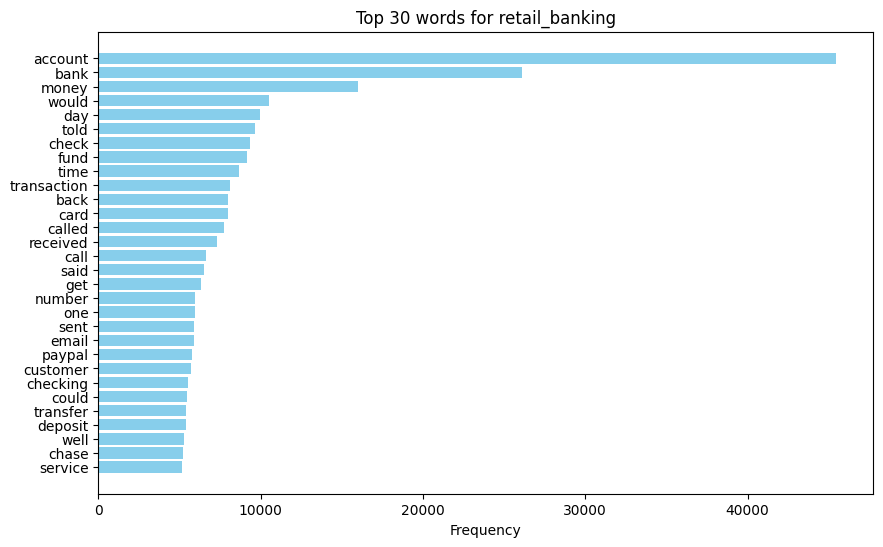

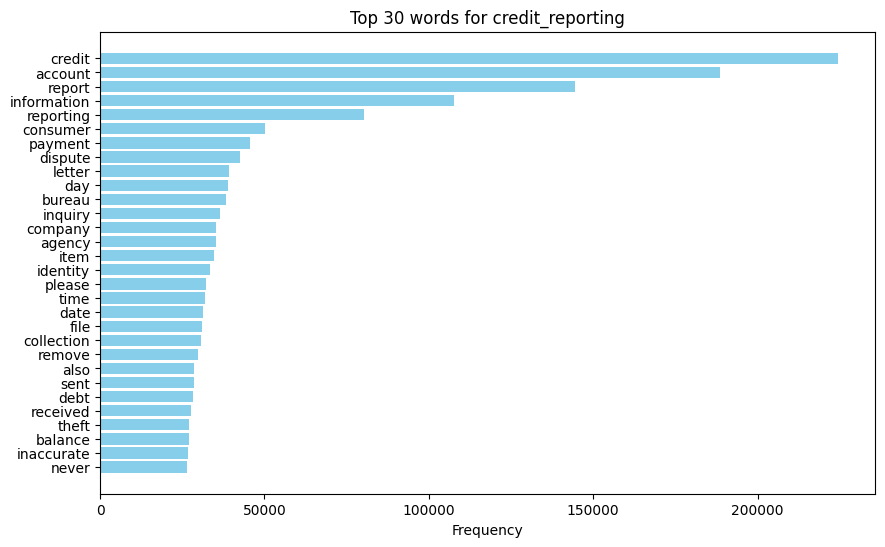

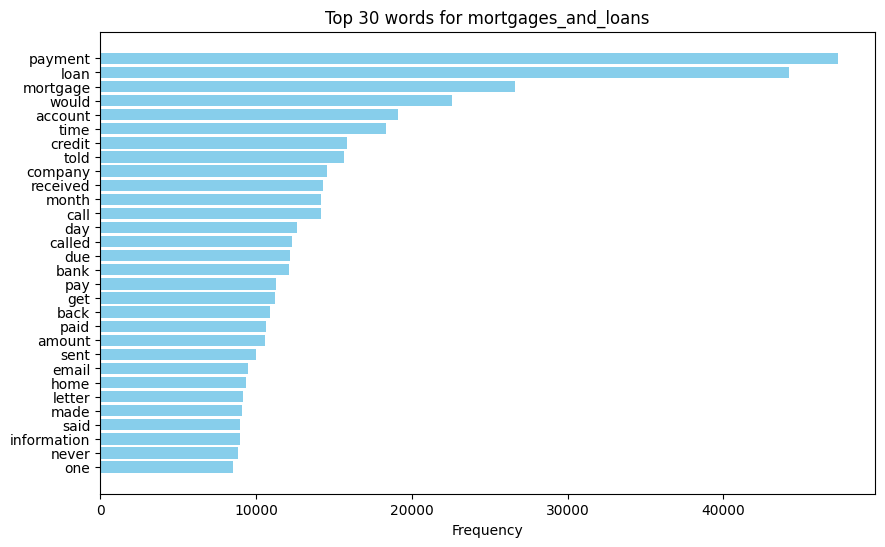

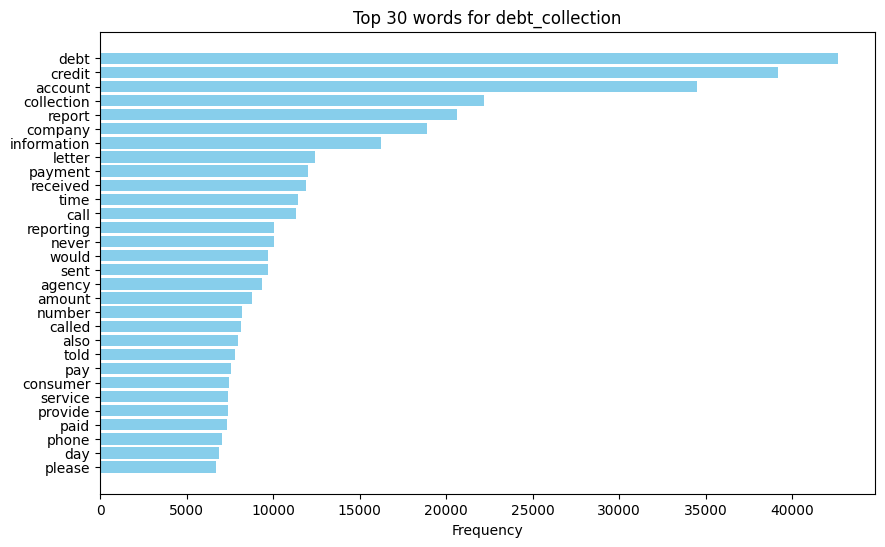

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to process and return top words and their counts
def plot_top_words(data, product_label):
    text = ' '.join(data['cleaned_narrative'][data['product'] == product_label])
    # Tokenizing and counting words
    word_counts = Counter(text.split())
    top_words = word_counts.most_common(30)
    words, counts = zip(*top_words)
    return words, counts

# Get unique product labels
product_labels = df['product'].unique()

# Loop through each product label
for label in product_labels:
    # Get top words and their counts
    words, counts = plot_top_words(df, label)

    # Plot the top 30 words for the current product label
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 30 words for {label}')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()  # Display the plot


In [ ]:
# calculating text length.
if 'text_length' not in df.columns:
    df['text_length'] = df['cleaned_narrative'].apply(len)
# calculating word count
if 'number_of_words' not in df.columns:
    df['number_of_words'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))
# adding text length column(character count)
df['text_length'] = df['cleaned_narrative'].apply(len)
# adding word count column.
df['text_length'] = df['cleaned_narrative'].apply(lambda x: len(x.split()))
# displaying the relevant columns in the dataframe.
cleaned_df = df[['product','cleaned_narrative','text_length','number_of_words']]
cleaned_df.head()

,product,cleaned_narrative,text_length,number_of_words
0,credit_card,purchase order day shipping amount receive pro...,230,230
1,credit_card,forwarded message date tue subject please inve...,132,132
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,173
3,credit_reporting,payment history missing credit report speciali...,131,131
4,credit_reporting,payment history missing credit report made mis...,123,123


Created a df which includes the product,cleaned_narrative,text_length and number_of_words columns for easy look through

In [ ]:
cleaned_df = cleaned_df.copy()
label_encoder = LabelEncoder()
cleaned_df['target'] = label_encoder.fit_transform(cleaned_df['product'])
cleaned_df.head()

,product,cleaned_narrative,text_length,number_of_words,target
0,credit_card,purchase order day shipping amount receive pro...,230,230,0
1,credit_card,forwarded message date tue subject please inve...,132,132,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,173,4
3,credit_reporting,payment history missing credit report speciali...,131,131,1
4,credit_reporting,payment history missing credit report made mis...,123,123,1


In [ ]:
# creating a dictionary to map each product category to its numeric label
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print('Mapping of product categories to numeric targets:')
for product, target in label_mapping.items():
    print(f"{product} :{target}")

Mapping of product categories to numeric targets:
credit_card :0
credit_reporting :1
debt_collection :2
mortgages_and_loans :3
retail_banking :4


Data Transformation


In [ ]:
X = cleaned_df['cleaned_narrative']
y= cleaned_df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print('Training set shapes (X_train,y_train):',X_train.shape,y_train.shape)
print("Testing set shapes (X_test,y_test):",X_test.shape,y_test.shape)

Training set shapes (X_train,y_train): (129928,) (129928,)
Testing set shapes (X_test,y_test): (32483,) (32483,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())
X_test_scaled = scaler.transform(X_test_tfidf.toarray())

print('Scaled Training set shape:',X_train_scaled.shape)
print('Scaled Testing set shape:',X_test_scaled.shape)

Scaled Training set shape: (129928, 5000)
Scaled Testing set shape: (32483, 5000)


Model Training

Mulitnomial Naive Bayes Model

In [ ]:
# initializing and training the Multinomial Naive Bayes model
baseline_nb_model = MultinomialNB()
baseline_nb_model.fit(X_train_scaled, y_train)

y_pred_base_nb = baseline_nb_model.predict(X_test_scaled)
# sorting label_mapping by numeric target to ensure correct order
target_names = [product for product,target in sorted(label_mapping.items(),key=lambda item: item[1])]

#calculating accuracy and classification report with target names
accuracy_base_nb = accuracy_score(y_test,y_pred_base_nb)
report_base_nb = classification_report(y_test,y_pred_base_nb, target_names=target_names)

print(f'Accuracy (Baseline MultinomialNB):{accuracy_base_nb}')
print('Classification Report(Baseline MultinomialNB):\n',report_base_nb)

Accuracy (Baseline MultinomialNB):0.8233229689375982
Classification Report(Baseline MultinomialNB):
                      precision    recall  f1-score   support

        credit_card       0.66      0.74      0.70      3113
   credit_reporting       0.90      0.87      0.88     18235
    debt_collection       0.77      0.65      0.70      4630
mortgages_and_loans       0.71      0.86      0.78      3798
     retail_banking       0.80      0.86      0.83      2707

           accuracy                           0.82     32483
          macro avg       0.77      0.80      0.78     32483
       weighted avg       0.83      0.82      0.82     32483



The Multinomial Naive Bayes model achieved a Macro F1 score of 0.78 and Weighted F1-score of 0.82,indicating moderate overall performance with some variations across classes.The model performs well in identifying credit_reporting and retail_banking complaints,which have high F1-scores of (0.88 and 0.83 respectively),but struggles with credit_card(0.70) and debt_collection(0.70) categories,where F1-scores are lower.This suggests that while the model is fairly accurate overall,it lacks consistency across all complaint types,as seen in the lower Macro F1-scores

Support Vector Machine Model

In [ ]:
# initializing and training the SVM model
baselines_svm_model = LinearSVC(max_iter = 1000,random_state = 42)
baselines_svm_model.fit(X_train_scaled,y_train)

y_pred_base_svm = baselines_svm_model.predict(X_test_scaled)
target_names = [product for product, target in sorted(label_mapping.items(),key=lambda item: item[1])]

accuracy_base_svm = accuracy_score(y_test,y_pred_base_svm)
report_base_svm = classification_report(y_test,y_pred_base_svm,target_names = target_names)

print(f"Accuracy (Baseline SVM): {accuracy_base_svm}")
print("Classification Report (Baseline SVM):\n", report_base_svm)

Accuracy (Baseline SVM): 0.8679924883785365
Classification Report (Baseline SVM):
                      precision    recall  f1-score   support

        credit_card       0.78      0.76      0.77      3113
   credit_reporting       0.90      0.93      0.92     18235
    debt_collection       0.80      0.73      0.77      4630
mortgages_and_loans       0.85      0.81      0.83      3798
     retail_banking       0.85      0.86      0.85      2707

           accuracy                           0.87     32483
          macro avg       0.84      0.82      0.83     32483
       weighted avg       0.87      0.87      0.87     32483



The Support Vector Machine(SVM) model achieved a Macro F1-score of 0.83 and Weighted F1-score of 0.87 ,demonstrating stronger and more balanced performance across classes compared to the previous Multinomial Naive Bayes model.The SVM model performs especially well on credit_reporting with an F1-score of 0.92 and retail_banking with an F1-score of 0.85,indicating effective classification in these categories.While credit_card(0.77) and debt_collection(0.77) categories have a lower F1-scores,they still show improvement over the Multinomial Naive Bayes model.

Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
# initializing and training the LogisticRegression model
baselines_lr_model = LogisticRegression(max_iter = 1000,random_state = 42)
baselines_lr_model.fit(X_train_scaled,y_train)

y_pred_base_lr = baselines_lr_model.predict(X_test_scaled)
target_names = [product for product,target in sorted(label_mapping.items(), key=lambda item: item[1])]

accuracy_base_lr = accuracy_score(y_test,y_pred_base_lr)
report_base_lr = classification_report(y_test,y_pred_base_lr,target_names = target_names)

print(f"Accuracy (Baseline Logistic Regression): {accuracy_base_lr}")
print("classification Report (Baseline Logistic Regression):\n",report_base_lr)

Accuracy (Baseline Logistic Regression): 0.8731952098020503
classification Report (Baseline Logistic Regression):
                      precision    recall  f1-score   support

        credit_card       0.79      0.78      0.78      3113
   credit_reporting       0.91      0.94      0.92     18235
    debt_collection       0.81      0.73      0.77      4630
mortgages_and_loans       0.85      0.82      0.84      3798
     retail_banking       0.87      0.87      0.87      2707

           accuracy                           0.87     32483
          macro avg       0.85      0.83      0.84     32483
       weighted avg       0.87      0.87      0.87     32483



The Logistic Regression model achieved a Macro F1-score of 0.84 and a weighted F1-score of 0.87,showing solid and balanced performance across classes,similar to the SVM model.This model performs particularly well on credit_reporting with a F1-score of 0.92 and retail_banking with an F1-score of 0.87,indicating effective classification in these categories.The credit_card and debt_collection categories have a lower F1-scores of from the SVM model.Compared to SVM,Logistic Regression shows slightly higher F1-scores in mortgages_and_loans and retail_banking thou overall performance is close

Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestClassifier
baselines_rf_model = RandomForestClassifier(random_state=42)
baselines_rf_model.fit(X_train_scaled, y_train)

y_pred_base_rf = baselines_rf_model.predict(X_test_scaled)

target_names = [product for product,target in sorted(label_mapping.items(), key = lambda item: item[1])]

accuracy_base_rf = accuracy_score(y_test,y_pred_base_rf)
report_base_rf = classification_report(y_test,y_pred_base_rf,target_names = target_names)

print(f"Accuracy (Baseline Random Forest): {accuracy_base_rf}")
print("Classification Report (Baseline Random Forest):\n",report_base_rf)

Accuracy (Baseline Random Forest): 0.8835390819813441
Classification Report (Baseline Random Forest):
                      precision    recall  f1-score   support

        credit_card       0.82      0.72      0.77      3113
   credit_reporting       0.89      0.97      0.93     18235
    debt_collection       0.89      0.72      0.80      4630
mortgages_and_loans       0.89      0.80      0.84      3798
     retail_banking       0.85      0.85      0.85      2707

           accuracy                           0.88     32483
          macro avg       0.87      0.81      0.84     32483
       weighted avg       0.88      0.88      0.88     32483



The Random Forest model achieved a Macro F1-score of 0.84 and a Weighted F1-score of 0.88,indicating robust and balanced performance across all classes.
***credit_reporting*** has a F1-score of 0.93 and ***retail_banking*** 0.85.The ***credit_card*** and and ***debt_collection*** with F1-scores of 0.77 and 0.80 respectively.Random Forest demonstrates a slightly higher Weighted F1-score than the other models, suggesting better performance on the more frequent classes,this shows consistent classification across all categories.

Model Improvement

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
# applying TF-IDF transformation.
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())
X_test_scaled = scaler.transform(X_test_tfidf.toarray())

print("Scaled Training set shape before SMOTE:",X_train_scaled.shape)
print("Scaled Testing set shape before SMOTE:",X_test_scaled.shape)

#applying SMOTE on the scaled training set

smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled,y_train)
print("Resampled Training set shape:",X_train_resampled.shape)
print("Resampled Testing set shape:",X_test_scaled.shape)

Scaled Training set shape before SMOTE: (129928, 5000)
Scaled Testing set shape before SMOTE: (32483, 5000)
Resampled Training set shape: (364445, 5000)
Resampled Testing set shape: (32483, 5000)
